## The Sample Problem

Consider a system that tries to map groups of 3 inputs to some corresponding output which is a single number. In the following picture, we'll show each set of 3 inputs as a row of a matrix $X$, and each output as the corresponding row of $Y$:

$$ \overbrace{
 \left[ {\begin{array}{ccc}
   0 & 0 & 1 \\
   0 & 1 & 1\\
   1 & 0 & 1\\
   1 & 1 & 1\\
  \end{array} } \right]
}^{X} \rightarrow
\overbrace{
 \left[ {\begin{array}{c}
   0   \\
   0  \\
   1  \\
   1 \\
  \end{array} } \right]
  }^Y.
$$

Even though this system has an exact solution (namely, $Y$ equals the first column of $X$), usually we'll need to be satisfied with a system that maps our inputs $X$ to some approximate "prediction" $\tilde{Y}$, which we hope to bring closer to the "target" $Y$ by means of successive improvements. 

The way we'll get our prediction $\tilde{Y}$ is by means of a weighted sum of each set of 3 inputs, and some nonlinear function $f$ which we call the "[activation function](https://en.wikipedia.org/wiki/Activation_function)" (or just "activation").   Pictorially, the process looks like the following, for each row $i$ of $X$ and $Y$, (where the columns of $X$ are shown arranged vertically instead of horizonally):


![image of NN](https://i.imgur.com/7Oj5Ksn.png)

In terms of matrix multiplication, since X is a 4x3 matrix, and Y is a 4x1 matrix, that implies that our weights should be a 3x1 matrix consisting of (unknown) values $w_0$, $w_1$ and $w_2$. The calculation can be written as:

$$
f\left(
  \overbrace{
 \left[ {\begin{array}{ccc}
   0 & 0 & 1 \\
   0 & 1 & 1\\
   1 & 0 & 1\\
   1 & 1 & 1\\
  \end{array} } \right]
}^\text{X} 
\overbrace{
   \left[ {\begin{array}{c}
   w_0  \\
    w_1\\
   w_2\\
  \end{array} } \right]
 }^{w}
\right)
  = 
  \overbrace{
 \left[ {\begin{array}{c}
   0   \\
   0  \\
   1  \\
   1 \\
  \end{array} } \right]
 }^{\tilde{Y}}
$$


Our nonlinear activation function $f$ is taken to operate on each row element one at a time, and we'll let $f_i$ denote the $i$th row of this completed activation, i.e.:

$$
f_i = f\left( \sum_j X_{ij}w_j \right) = \tilde{Y}_i .
$$


The particular activation function we will use is the "sigmoid",

$$
f(x) = {1\over{1+e^{-x}}}, 
$$
-- [click here to see a plot of this function](https://www.google.com/search?q=plot+1%2F(1%2Bexp(-x) -- which has the derivative 

$$
{df\over dx} = {e^{-x}\over(1 + e^{-x})^2}
$$
which can be shown (*Hint: exercise for "mathy" students!*) to simplify to
$$
 {df\over dx}= f(1-f).
$$

The overall problem then amounts to finding the values of the "weights" $w_0, w_1,$ and $w_2$ so that the $\tilde{Y}$ we calculate is as close to the target $Y$ as possible.

To do this, we will seek to minimize a loss function defined as a sum across all data points we have, i.e. all 4 rows. The loss function $L$ we will choose is the mean square error loss, or MSE (note: later in [Part 2](https://drscotthawley.github.io/blog/2019/02/04/My-First-NN-Part-2.html) we will use a 'better' loss function for this problem):

$$
L = {1\over N}\sum_{i=0}^{N-1} \left[ \tilde{Y}_i - Y_i\right]^2,
$$
or in terms of the activation function
$$
L = {1\over N}\sum_{i=0}^{N-1} \left[ f_i - Y_i\right]^2.
$$

Each of the weights $w_j$ ($j=0..2$) will start with random values, and then be updated via gradient descent, i.e. 

$$
w_j^{new} = w_j^{old} - \alpha{\partial L\over \partial w_j}
$$

where $\alpha$ is the *learning rate*, chosen to be some small parameter.
For the MSE loss shown above,  the partial derivatives with respect to each of the weights is

$$
{\partial L\over \partial w_j} = {2\over N}\sum_{i=0}^{N-1} \left[ \tilde{Y}_i - Y_i\right]{\partial f_i \over \partial w_j}\\
= {2\over N}\sum_{i=0}^{N-1} \left[ \tilde{Y}_i - Y_i\right]f_i(1-f_i)X_{ij}.
$$

Absorbing the factor of 2/N into our choice of $\alpha$, and writing the summation as a dot product, and noting that $f_i = \tilde{Y}_i$, we can write the update for all the weights together as 

$$
w = w - \alpha  X^T \cdot \left( [\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})\right)
$$
where the $\cdot$ denotes a matrix-matrix product (i.e. a dot product for successive rows of $X^T$) and $*$ denotes elementwise multiplication.  

To clarify the above expression in terms of matrix dimensions, we can see that $w$, a 3x1 matrix, can be made by multipyting $X^T$ (a 3 x4 matrix) with the term in parentheses, i.e. the product of elementwise terms involving $\tilde{Y}$, which is a 4x1 matrix.  In other words, a 3x4 matrix, times a 4x1 matrix, yields a 3x1 matrix. 

## Actual Code
The full code for all of this is then...

In [1]:
# Source: Slightly modified from Andrew Trask's code posted at 
#         https://iamtrask.github.io/2015/07/12/basic-python-network/
import numpy as np

# sigmoid activation
def sigmoid(x,deriv=False): 
  if(deriv==True):
    return x*(1-x)
  return 1/(1+np.exp(-x))
    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# target output dataset            
Y = np.array([[0,0,1,1]]).T

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly with mean 0
w = 2*np.random.random((3,1)) - 1

alpha = 1.0   # learning rate

loss_history = []    # keep a record of how the loss proceeded, blank for now
for iter in range(1000):

    # forward propagation
    Y_pred = sigmoid(np.dot(X,w)) # prediction, i.e. tilde{Y}

    # how much did we miss?
    diff = Y_pred - Y
    loss_history.append((diff**2).mean())   # add to the history of the loss

    # update weights
    w -= alpha * np.dot( X.T, diff*sigmoid(Y_pred, deriv=True))

print("Output After Training:")
print("Y_pred = (should be two 0's followed by two 1's)\n",Y_pred)
print("weights =\n",w)

Output After Training:
Y_pred = (should be two 0's followed by two 1's)
 [[0.03178421]
 [0.02576499]
 [0.97906682]
 [0.97414645]]
weights =
 [[ 7.26283009]
 [-0.21614618]
 [-3.41703015]]


Note that, because of our nonlinear activation, we *don't* get the solution $w_0=1, w_1=0, w_2=0$.

Plotting the loss vs. iteration number, we see...

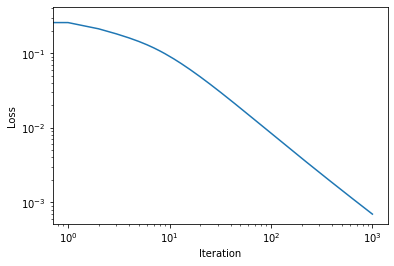

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.loglog(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Change the activation function

Another popular choice of activation function is the *rectified linear unit* or ReLU.  The function ReLU(x) is zero for x <= 0, and equal to x (i.e. a straight line at 45 degrees for)  x >0.  It can be written as max(x,0) or  x * (x>0), and its derivative is 1 for positive x, and zero otherwise. 

[Click here to see a graph of ReLU](https://www.desmos.com/calculator/vjqfxlgmzl)

Modifying our earlier code to use ReLU activation instead of sigmoid looks like this:

In [3]:
def relu(x,deriv=False):   # relu activation
  if(deriv==True):
    return 1*(x>0) 
  return x*(x>0)

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly  (but only >0 because ReLU clips otherwise)
w = np.random.random((3,1))

alpha = 0.3   # learning rate

new_loss_history = []    # keep a record of how the error proceeded
for iter in range(1000):

    # forward propagation
    Y_pred = relu(np.dot(X,w))

    # how much did we miss?
    diff = Y_pred - Y
    new_loss_history.append((diff**2).mean())   # add to the record of the loss

    # update weights
    w -= alpha * np.dot( X.T, diff*relu(Y_pred, deriv=True))

print("Output After Training:")
print("Y_pred = (should be two 0's followed by two 1's)\n",Y_pred)
print("weights =\n",w)

Output After Training:
Y_pred = (should be two 0's followed by two 1's)
 [[-0.]
 [-0.]
 [ 1.]
 [ 1.]]
weights =
 [[ 1.01784368e+00]
 [ 8.53961786e-17]
 [-1.78436793e-02]]


In [4]:
# Aside/Trivia (you can skip this cell): I find it interesting that apparently w2 = 1-w0
print( w[2] - (1-w[0]) )

[-3.46944695e-17]


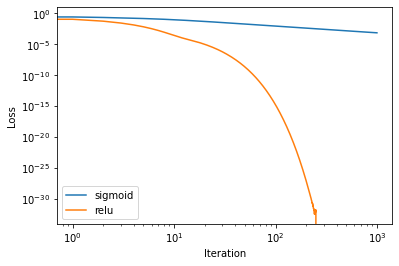

In [5]:
#old results with new results

%matplotlib inline
import matplotlib.pyplot as plt
plt.loglog(loss_history,label="sigmoid")
plt.loglog(new_loss_history,label="relu")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Exercise: Read a 7-segment display

A [7-segment display](https://en.wikipedia.org/wiki/Seven-segment_display) is used for displaying numerical digits 0 through 9, usually by lighting up LEDs or parts of a liquid crystal display (LCD).  The segments are labelled $a$ through $g$ according to the following diagram:

![7-segment diagram](https://i.imgur.com/ZyHGDKy.png) 

### Diagram of the network
The 7 inputs "a" through "g" will be mapped to 10 outputs for the individual digits, and each output can range from 0 ("false" or "no") to 1 ("true" or "yes") for that digit.  The input and outputs will be connected by a matrix of weights.  Pictorially, this looks like the following (Not shown: activation function $f$):

![diagram of 7-seg network](https://i.imgur.com/mERzmFE.png)

...where again, this network operates on a single data point at a time, datapoints which are *rows* of *X* and *Y*.  What is shown in the above diagram are the *columns* of $X$ and $Y$ for a single row (/ single data point).

### Create the dataset
Let the input X be the segments $a$ through $g$ are the columns of the input $X$, and are either 1 for on or 0 for off.  Let the columns of the target $Y$ be the digits 0-9 themselves arranged in a ["one hot" encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) scheme, as follows:


<table>
  <tr><td>Digit</td><td>One-Hot Encoding for $Y$</td></tr>
    <tr><td>0</td><td>1,0,0,0,0,0,0,0,0,0</td></tr>
    <tr><td>1</td><td>0,1,0,0,0,0,0,0,0,0</td></tr>
    <tr><td>2</td><td>0,0,1,0,0,0,0,0,0,0</td></tr>
  <tr><td>...</td><td>...</td></tr>
    <tr><td>9</td><td>0,0,0,0,0,0,0,0,0,1</td></tr>
  </table>
  The values in the columns for $Y$ are essentially true/false "bits" for each digit, answering the question "Is this digit the appropriate output?" with a "yes"(=1) or "no" (=0) response. 

The input $X$ will be a 10x7 matrix, and the target $Y$ will be a 10x10 matrix. Each row of $X$ will be the segments to produce the digit for that row.  For example, the zeroth row of $X$ should show segments on which make an image of the digit zero, namely segments a, b, c, d, e, and f but not g, so that the zeroth row of X should be [1,1,1,1,1,1,0].

Define numpy arrays for both $X$ and $Y$  (Hint: for $Y$, check out [np.eye()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html)): 



In [ ]:
# Students: fill these out completely for what the X and Y *should* be
# for the 7-segment display.  The following is just a "stub" to get you started.
X = np.array([ [1,1,1,1,1,1,0],
               [],
               [],
               [] ])
Y = np.array([ [1,0,0,0,0,0,0,0,0,0],
               [],
               [] ])

### Initialize the weights
Previously the dimensions of the weight matrix $w$ were 3x1 because we were mapping each row of 3 elements in $X$ to each row of 1 element of $Y$.  For this new problem,
each row of $X$ has 7 elements, and we want to map those to the 10 elements in each 1-hot-encoded row of $Y$, so what should the dimensions of the weights matrix $w$ be? 

Write some numpy code to randomly initialize the weights matrix:

In [ ]:
np.random.seed(1)  # initial RNG so everybody gets similar results

w = np.random.random(( , ))    # Students, fill in the array dimensions here

### Train the network
Having created an $X$ and its matching $Y$, and initalized the weights $w$ randomly, train a neural network such as the ones above to learn to map a row of X to a row of Y, i.e. train it to recognize digits on 7-segment displays.  Do this below.

In [ ]:
# Students, copy training code from above and paste it here. 
#  Use sigmoid activation, and 1000 iterations, and learning rate of 0.9
#    Question: What happens if you use ReLU instead? Try it later. Is ReLU always the best choice?


# And then print out your Y_pred & weights matrix, and limit it to 3 significant digits
print("Output After Training:")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # 3 sig figs
print("Y_pred=\n",Y_pred)
print("weights =\n",repr(w))  # the repr() makes it so it can be copied & pasted back into Python code

## Final Check: Keras version

[Keras](https://keras.io/) is a neural network library that lets us write NN applications very compactly.  Try running the following using the X and Y from your 7-segment dataset:

In [ ]:
# Just a demo of how one might similarly train a network using Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential([
    Dense(10, input_shape=(7,)),
    Activation('sigmoid') ])
model.compile(optimizer='adam',   # We'll talk about optimizer choices and loss choices later
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X, Y, epochs=200, batch_size=1)
print("\nY_tilde = \n", model.predict(X) )

In [ ]:
#https://drscotthawley.github.io/blog/2019/02/04/My-First-NN-Part-2.html


In [ ]:
#https://drscotthawley.github.io/blog/2019/02/08/My-1st-NN-Part-3-Multi-Layer-and-Backprop.html